# Assignment 1

## Task 1: Corpus

1.1 Packages

In [1]:
# download
import wget
import zipfile
import os
import gensim.downloader as gloader
from pathlib import Path

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tokenization
from collections import OrderedDict
from tqdm import tqdm

# model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.layers import Masking




In [2]:
random_seed1 = 101
random_seed2 = 102
random_seed3 = 103

1.2 Dataset download

In [3]:
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_name = 'dependency_treebank'

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")
print(dataset_folder)

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    wget.download(url, out=str(dataset_folder))

if not dataset_path.exists():
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
print('\n\n')     

# Visualize an example
print('** EXAMPLE **\n')
file_path = dataset_folder.joinpath(dataset_name, dataset_name, 'wsj_0001.dp')
if file_path.is_file():
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)
else:
    print('error in accessing the file')


Current work directory: c:\Users\ricca\Desktop\Università\nlp\assignments\Assignment 1
c:\Users\ricca\Desktop\Università\nlp\assignments\Assignment 1\Datasets



** EXAMPLE **

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



1.3 Dataframe encoding

In [4]:
text_list = []
labels_list = []
doc_list = []

folder = dataset_folder.joinpath(dataset_name, dataset_name)
for file_path in folder.glob('*.dp'):
    with open(os.path.join(folder, file_path), 'r') as file:
        doc_num = int(str(file_path)[-7:-3]) #save doc number
        lines = file.readlines()

        text = ' '.join(line.split()[0] if len(line.split()) > 0 else '' for line in lines)
        labels = [line.split()[1] if len(line.split()) > 1 else '' for line in lines]

        text_list.append(text)
        labels_list.append(labels)
        doc_list.append(doc_num)

#text_list
    

In [5]:
text_list_splitted = []
doc_num_splitted = []

for i in range(len(text_list)):
    chunks = [chunk for chunk in text_list[i].split('  ') if chunk]
    doc = [doc_list[i] for x in range(len(chunks))]
    text_list_splitted.extend(chunks)
    doc_num_splitted.extend(doc)



labels_list_splitted = []
for sublist in labels_list:
    chunks = [[]]
    for item in sublist:
        if item == '':
            if chunks[-1]:
                chunks.append([])
        else:
            chunks[-1].append(item)
    labels_list_splitted.extend(chunks)

#Check dimensions
print(f"the length of labels is {len(labels_list_splitted)}")
print(f"the length of text is {len(text_list_splitted)}")

#dataframe
df = pd.DataFrame({'text' : text_list_splitted,'labels' : labels_list_splitted, 'doc_num' : doc_num_splitted})
df.head()

the length of labels is 3914
the length of text is 3914


,text,labels,doc_num
0,"Pierre Vinken , 61 years old , will join the b...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"Rudolph Agnew , 55 years old and former chairm...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,A form of asbestos once used to make Kent ciga...,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"The asbestos fiber , crocidolite , is unusuall...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


1.4 Preprocessing

In [6]:
# Since words with capital letters are not present in the GloVe encoding, 
# we trasnform all of them in small letters.
df['text'] = df['text'].str.lower()
df.head()

,text,labels,doc_num
0,"pierre vinken , 61 years old , will join the b...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"mr. vinken is chairman of elsevier n.v. , the ...","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"rudolph agnew , 55 years old and former chairm...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,a form of asbestos once used to make kent ciga...,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"the asbestos fiber , crocidolite , is unusuall...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


1.5 Vocabulary construction

In [7]:
# Building the vocabulary
def build_vocabulary(df):
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1
    
    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

# Evaluation of the vocabulary
def evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df, check_default_size = False):
    print('[Vocabulary Evaluation] Size checking...')
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print('[Vocabulary Evaluation] Content checking...')
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i
    
    print('[Vocabulary Evaluation] Consistency checking...')
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print('[Vocabulary Evaluation] Toy example checking...')
    toy_df = pd.DataFrame.from_dict({'text': ["all that glitters is not gold", "all in all i like this assignment"]})
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.text.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary

In [8]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
print(f'[Debug]  Index -> Word  vocabulary size: {len(idx_to_word)}')
print(f'[Debug]  Word -> Index  vocabulary size: {len(word_to_idx)}')
print(f'[Debug]  Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')

print('\n\n')

print('Vocabulary evaluation...')
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)
print('\nEvaluation completed!')

100%|██████████| 3914/3914 [00:00<00:00, 217437.16it/s]


[Debug]  Index -> Word  vocabulary size: 10947
[Debug]  Word -> Index  vocabulary size: 10947
[Debug]  Some words: [('vinken', 1), (',', 2), ('61', 3), ('years', 4), ('old', 5), ('will', 6), ('join', 7), ('the', 8), ('board', 9), ('as', 10)]



Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 10947/10947 [00:00<00:00, 3578167.54it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 3914/3914 [00:00<00:00, 186413.51it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<?, ?it/s]


Evaluation completed!


1.6 Dataframe splitting and evaluation

In [9]:
train = df.loc[df['doc_num']<=100]
validation = df.loc[df['doc_num']>100]
validation = validation.loc[df['doc_num']<151]
test = df.loc[df['doc_num']>150]

# size check
print(f' size of training set: {train.shape[0]}, \n size of validation set: {validation.shape[0]},\n size of test set: {test.shape[0]}')

 size of training set: 1963, 
 size of validation set: 1299,
 size of test set: 652


In [10]:
# Function to compute the percentage of each label
def percentage_of_tags(df ,prt = True):
    labels = [x for y in df['labels'] for x in y]
    uniques = {}
    for i in labels:
        if i in uniques:
            uniques[i] += 1
        else:
            uniques[i] = 1
    count = sum(uniques.values())
    if prt == True:
            uniques_sorted = sorted(uniques.items(), key=lambda x: x[1], reverse = True)
            print(f'Percentage for Tags is:\n')
            print('-'*15)
            for i, j in uniques_sorted:
                percentage = (j / count) * 100
                print(f'{i:<8} | {j} | {percentage:.2f}%')
            print('-'*15)
    
    return 

In [11]:
percentage_of_tags(df)

Percentage for Tags is:

---------------
NN       | 13166 | 13.99%
IN       | 9857 | 10.48%
NNP      | 9410 | 10.00%
DT       | 8165 | 8.68%
NNS      | 6047 | 6.43%
JJ       | 5834 | 6.20%
,        | 4886 | 5.19%
.        | 3874 | 4.12%
CD       | 3546 | 3.77%
VBD      | 3043 | 3.23%
RB       | 2822 | 3.00%
VB       | 2554 | 2.71%
CC       | 2265 | 2.41%
TO       | 2179 | 2.32%
VBN      | 2134 | 2.27%
VBZ      | 2125 | 2.26%
PRP      | 1716 | 1.82%
VBG      | 1460 | 1.55%
VBP      | 1321 | 1.40%
MD       | 927 | 0.99%
POS      | 824 | 0.88%
PRP$     | 766 | 0.81%
$        | 724 | 0.77%
``       | 712 | 0.76%
''       | 694 | 0.74%
:        | 563 | 0.60%
WDT      | 445 | 0.47%
JJR      | 381 | 0.40%
NNPS     | 244 | 0.26%
WP       | 241 | 0.26%
RP       | 216 | 0.23%
JJS      | 182 | 0.19%
WRB      | 178 | 0.19%
RBR      | 136 | 0.14%
-RRB-    | 126 | 0.13%
-LRB-    | 120 | 0.13%
EX       | 88 | 0.09%
RBS      | 35 | 0.04%
PDT      | 27 | 0.03%
#        | 16 | 0.02%
WP$      | 14 | 0.01

## **Task 2: Text Encoding**

2.1 GloVe embedding

In [12]:
def load_glove(embedding_dimension):
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension!")
        raise e
    
    return emb_model

embedding_model = load_glove(embedding_dimension=100)

2.2 Out Of Vocabulary (OOV) terms checking

In [13]:
def check_OOV_terms(embedding_model, word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(f'\n\nSome OOV words: {[oov_terms[i] for i in range(10)]}')
for i in oov_terms:
    print(i)



Total OOV terms: 676 (6.18%)


Some OOV words: ['anti-takeover', 'blood-cell', '143.80', 'noncompetitively', 'low-ability', 'bridgestone\\/firestone', '62.625', 'one-upsmanship', 'intelogic', 'lentjes']
anti-takeover
blood-cell
143.80
noncompetitively
low-ability
bridgestone\/firestone
62.625
one-upsmanship
intelogic
lentjes
gingl
arbitraging
life-insurance
sino-u.s.
intecknings
safe-deposit
bellringers
savings-and-loan
wheel-loader
hummerstone
ac-130u
22\/32
change-ringing
-rrb-
ft-se
anti-abortionists
lafite-rothschild
odd-year
million-a-year
ghkm
3,250,000
415.6
hadson
three-lawyer
muscolina
62%-owned
school-board
352.9
lookee-loos
sidak
2\/32
clean-air
pension-fund
unfair-trade
bankruptcy-law
junk-bond
38.875
nofzinger
23,403
money-market
7.272
352.7
319.75
377.60
romanee-conti
macmillan\/mcgraw
188.84
subindustry
post-hearing
16,072
foreign-led
high-rolling
triple-a-rated
stock-selection
anti-program
centerbank
college-bowl
limited-partnership
rapanelli
investment-grade
weisfield


Since the OOV words percentage is not negligible we handle OOV words by assigning them a specific word vector.

Many of the oov words are composed words, so we handled them in this way: if the words that compose the oov composed word are present in the embedding, the assigned embedding to the oov word is an average of the two embeddings that compose the oov word.

In [14]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, vocab_size):
    
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            if '-' in word:
                subwords = word.split('-')
                subword_embeddings = []

                for subword in subwords:
                    try:
                        subword_embedding = embedding_model[subword]
                        subword_embeddings.append(subword_embedding)
                    except KeyError:
                        subword_embeddings.append(np.random.uniform(low=-0.5, high=0.5, size=embedding_dimension))

                if subword_embeddings:
                    embedding_vector = np.mean(subword_embeddings, axis=0)
                else:
                    embedding_vector = np.random.uniform(low=-0.5, high=0.5, size=embedding_dimension)
            else:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix


2.3 Obtaining the Embedding Matrix

In [15]:
# Testing
embedding_dimension = 100
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx)+1)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 10947/10947 [00:00<00:00, 237996.74it/s]

Embedding matrix shape: (10948, 100)


## **Task 3 - Model Definition**

3.1 Creation of X and y and their encoding

In [16]:
df['text'] = df['text'].apply(lambda x: x.split())
df.head()


,text,labels,doc_num
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


In [17]:
# Function to perform the splitting of df into X and y
def df_splitting(df):
    X = []
    y = []
    for sentence in df['text']:
        X.append(sentence)
    for label in df['labels']:
        y.append(label)
    return X, y

# Function to tokenize the datasets
def tokenizer_function(X, y):
    word_tokenizer = Tokenizer()
    tag_tokenizer = Tokenizer()

    word_tokenizer.fit_on_texts(X)
    tag_tokenizer.fit_on_texts(y)

    X_encoded = word_tokenizer.texts_to_sequences(X)
    y_encoded = tag_tokenizer.texts_to_sequences(y)

    return X_encoded, y_encoded, tag_tokenizer


In [18]:
X, y = df_splitting(df)
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in y for word in sentence]))
print(f'\nnumber of words: {num_words}\nnumber of tags: {num_tags}')


number of words: 10947
number of tags: 45


In [19]:
X_encoded, y_encoded, tag_tokenizer = tokenizer_function(X, y)

# Checking
print('** Raw data point **', '\n\n', '-'*100, '\n')
print('X[0]: ', X[0], '\n')
print('y[0]: ', y[0], '\n')
print()
print('X[0]: ', X_encoded[0], '\n')
print('y[0]: ', y_encoded[0], '\n')

# Length check
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, y_encoded)]
print(f'{sum(different_length)} sentences have disparate input-output lengths.')
if (sum(different_length))==0:
    print('\nEverything is ok!!')
else:
    print(f'There are {sum(different_length)} sequences with different length.')

** Raw data point ** 

 ---------------------------------------------------------------------------------------------------- 

X[0]:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.'] 

y[0]:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 


X[0]:  [5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3] 

y[0]:  [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8] 

0 sentences have disparate input-output lengths.

Everything is ok!!


Length of longest sentence:  249 




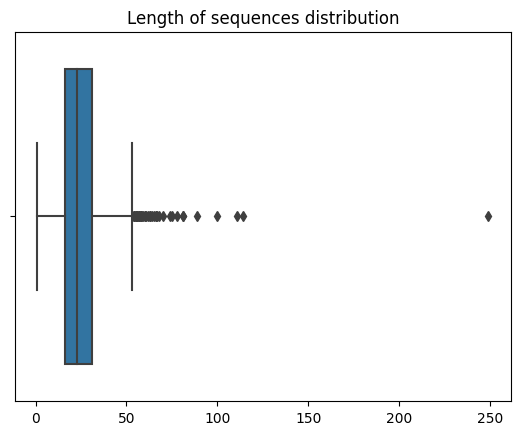

In [20]:
import seaborn as sns

# Check which is the longest sequence of our dataset
lengths = [len(seq) for seq in X_encoded]
print('Length of longest sentence: ', max(lengths), '\n\n')

# Check the distribution of the length of the sequences
sns.boxplot(lengths)
plt.title('Length of sequences distribution')
plt.show();

3.2 Padding the shorter sequences

In [21]:
# Function to pad the shorter functions
def padding_function(X_encoded, y_encoded, maxlen):
    # Padding
    Xpadded = pad_sequences(X_encoded, maxlen=maxlen, padding='pre', truncating='post')
    ypadded = pad_sequences(y_encoded, maxlen=maxlen, padding='pre', truncating='post')
    print('\nINTERMEDIATE RESULT: The first padded sequence:\n', Xpadded[0], '\n'*3, ypadded[0])

    ypadded = to_categorical(ypadded, num_classes=num_tags+1)
    ypadded = ypadded.astype(int)

    Xpadded = np.array(Xpadded)
    ypadded = np.array(ypadded)


    return Xpadded, ypadded

In [22]:
# Since the majority of the sequences is shorter than 50, we cap their length at 50
MAX_SEQ_LENGTH = 50

In [23]:
# Perform padding
Xpadded, ypadded = padding_function(X_encoded, y_encoded, MAX_SEQ_LENGTH)


INTERMEDIATE RESULT: The first padded sequence:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 5419 3714    1 2005   78  316    1   39 2383    2
  122   22    6 2006  317  444 2007    3] 


 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  3  3  7  9  5  6  7 20 12  4  1  2  4  6  1  3
  9  8]


3.4 X and y are divided in train, validation and test set

In [24]:
ltrain = len(train)
ltest = len(test)
lval = len(validation)

Xtrain = Xpadded[:ltrain]
ytrain = ypadded[:ltrain]

Xval = Xpadded[ltrain:ltrain+lval]
yval = ypadded[ltrain:ltrain+lval]

Xtest = Xpadded[ltrain+lval:]
ytest = ypadded[ltrain+lval:]

In [25]:
# Check on the dimensions
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(Xtrain.shape))
print('Shape of output sequences: {}'.format(ytrain.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(Xval.shape))
print('Shape of output sequences: {}'.format(yval.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(Xtest.shape))
print('Shape of output sequences: {}'.format(ytest.shape))

TRAINING DATA
Shape of input sequences: (1963, 50)
Shape of output sequences: (1963, 50, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1299, 50)
Shape of output sequences: (1299, 50, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (652, 50)
Shape of output sequences: (652, 50, 46)


3.5 Models Definition

In [37]:
# Useful variables
NUM_CLASSES = ypadded.shape[2]
VOCABULARY_SIZE = len(word_listing) + 1
Mask_el = 0

# Training parameters
num_epochs = 20
batch_size = 128
Mask_el = 0

In [29]:
# Function to define f1_score metric, so the model will try to maximize it at training time
def f1_score(y_true, y_pred):
    # Define precision and recall functions
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    # Calculate precision and recall
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)

    # Calculate F1 score
    f1_scores = 2 * (precision_val * recall_val) / (precision_val + recall_val + K.epsilon())
    macro_f1 = K.mean(f1_scores)
    
    return macro_f1

# Function to define the baseline model
def baseline(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = Sequential(name=name)
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    model.add(Masking(mask_value=Mask_el))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score])
    model.summary()

    return model

# Function to define Model 1
def model_1(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = Sequential(name=name)
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    model.add(Masking(mask_value=Mask_el))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(LSTM(128, return_sequences=True))
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score])
    model.summary()

    return model

# Function to define Model 2
def model_2(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = Sequential(name=name)
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    model.add(Masking(mask_value=Mask_el))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score])
    model.summary()

    return model

In [30]:
# Definition of the three baselines
baseline_1 = baseline(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'Baseline_1')
baseline_2 = baseline(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'Baseline_2')
baseline_3 = baseline(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'Baseline_3')


Model: "Baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1094800   
                                                                 
 masking (Masking)           (None, 50, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           234496    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 46)            11822     
 ributed)                                                        
                                                                 
Total params: 1341118 (5.12 MB)
Trainable params: 1341118 (5.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Baseline_2

In [31]:
# Definition of the three model 1
model_1_1 = model_1(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'MODEL1_seed1')
model_1_2 = model_1(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'MODEL1_seed2')
model_1_3 = model_1(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'MODEL1_seed3')

Model: "MODEL1_seed1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1094800   
                                                                 
 masking_3 (Masking)         (None, 50, 100)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 256)           234496    
 onal)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           197120    
                                                                 
 time_distributed_3 (TimeDi  (None, 50, 46)            5934      
 stributed)                                                      
                                                                 
Total params: 1532350 (5.85 MB)
Trainable params: 1532

In [32]:
# Definition of the three model 2
model_2_1 = model_2(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'MODEL2_seed1')
model_2_2 = model_2(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'MODEL2_seed2')
model_2_3 = model_2(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'MODEL2_seed3')

Model: "MODEL2_seed1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           1094800   
                                                                 
 masking_6 (Masking)         (None, 50, 100)           0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 256)           234496    
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (None, 50, 128)           32896     
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 50, 46)            5934      
 stributed)                                                      
                                                      

In [33]:
# Save the three kinds of models with their three seeds in three lists, for next steps
bases = [baseline_1, baseline_2, baseline_3]
models1 =[model_1_1, model_1_2, model_1_3]
models2 = [model_2_1, model_2_2, model_2_3]

## **TASK 4 - METRICS** 

N.B: Evaluation and computation of tp, fp, fn:

- True Positive (TP): This occurs when the model correctly predicts a positive (i.e., the correct POS tag) instance. For example, if the true POS tag is "NN" (noun) and the model predicts "NN," it's a true positive for the "NN" class.

- False Positive (FP): This happens when the model incorrectly predicts a positive instance. For example, if the true POS tag is "NN" (noun) but the model predicts "VB" (verb), it's a false positive for the "VB" class.

- False Negative (FN): This occurs when the model fails to predict a positive instance that should have been predicted. For instance, if the true POS tag is "NN" (noun) but the model predicts "O" (other), it's a false negative for the "NN" class.

4.1 Handling the punctuation tokens, that DO NOT have to be considered

In [34]:
# Save the tokens corresponding to english punctuation, since they have to be ignored at evaluation time
word_to_token = tag_tokenizer.word_index

english_punctuation = [',', '.', '``', '\'\'', ':', '-rrb-', '-lrb-']
punctuation_tokens = [token for word, token in word_to_token.items() if word in english_punctuation]
print('Punctuation tokens:\n', punctuation_tokens)

Punctuation tokens:
 [7, 8, 24, 25, 26, 35, 36]


4.2 Define the functions to compute the required metric (excluding the punctuation tokens)

In [55]:
# Define a function to accumulate tp, fp, fn for each class, iterating on all tokens
def tp_computation(ytrue, ypred, num_classes, punctuation_tokens):
    # Initialize counters
    tp = [0] * num_classes
    fp = [0] * num_classes
    fn = [0] * num_classes

    for true_labels, pred_labels in zip(ytrue, ypred):
        for true_label, pred_label in zip(true_labels, pred_labels):
            if true_label != 0 and true_label == pred_label and true_label not in punctuation_tokens:
                tp[true_label] += 1
            elif pred_label != 0 and pred_label not in punctuation_tokens:
                fp[pred_label] += 1
                fn[true_label] += 1

    return tp, fp, fn

# Compute the predictions 
def compute_predictions(model, X):
    ypred = model.predict(X, batch_size=batch_size)
    ypred_max = np.argmax(ypred, axis=-1)
    return ypred_max

def create_confusion_matrix(tp, fp, fn, tokens_to_avoid): 
    tp_fil = [element for index, element in enumerate(tp) if index not in tokens_to_avoid]
    fp_fil = [element for index, element in enumerate(fp) if index not in tokens_to_avoid]
    fn_fil = [element for index, element in enumerate(fn) if index not in tokens_to_avoid]
    
    tokens = [value for key, value in tag_tokenizer.index_word.items() if key not in tokens_to_avoid]
    
    totals = []
    macros = []
    for i in range(len(tp_fil)):
        total = tp_fil[i] + fn_fil[i]
        totals.append(total)
        precision = tp_fil[i] / (tp_fil[i] + fp_fil[i] + K.epsilon())
        recall = tp_fil[i] / (tp_fil[i] + fn_fil[i] + K.epsilon())
        f1_i = round(2 * (precision * recall) / (precision + recall + K.epsilon()), 2)
        macros.append(f1_i)
    data = {
        'tokens' : tokens,
        'total_occurences' : totals,
        'TP' : tp_fil,
        'FP' : fp_fil,
        'FN' : fn_fil,
        'f1-score' : macros
    }
    confusion_matrix_df = pd.DataFrame(data)
    return confusion_matrix_df

def macro_f1_score(confusion_matrix):
    f1_scores = []
    weights = []
    for item, row in confusion_matrix.iterrows():
        if(row['TP'] + row['FP'] + row['FN']) != 0:
            precision = row['TP'] / (row['TP'] + row['FP'] + 1e-10)
            recall = row['TP'] / (row['TP'] + row['FN'] + 1e-10)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            f1_scores.append(f1)

            weight = row['TP'] + row['FN']
            weights.append(weight)
    
    macro_f1 = sum(f1_scores) / len(f1_scores)
    weighted_f1 = sum(w * f for w, f in zip(weights, f1_scores)) / sum(weights)
    return round(macro_f1, 3), round(weighted_f1, 3)

print(punctuation_tokens)
tag_tokenizer.index_word

[0, 7, 8, 24, 25, 26, 35, 36]


{1: 'nn',
 2: 'in',
 3: 'nnp',
 4: 'dt',
 5: 'nns',
 6: 'jj',
 7: ',',
 8: '.',
 9: 'cd',
 10: 'vbd',
 11: 'rb',
 12: 'vb',
 13: 'cc',
 14: 'to',
 15: 'vbn',
 16: 'vbz',
 17: 'prp',
 18: 'vbg',
 19: 'vbp',
 20: 'md',
 21: 'pos',
 22: 'prp$',
 23: '$',
 24: '``',
 25: "''",
 26: ':',
 27: 'wdt',
 28: 'jjr',
 29: 'nnps',
 30: 'wp',
 31: 'rp',
 32: 'jjs',
 33: 'wrb',
 34: 'rbr',
 35: '-rrb-',
 36: '-lrb-',
 37: 'ex',
 38: 'rbs',
 39: 'pdt',
 40: '#',
 41: 'wp$',
 42: 'ls',
 43: 'fw',
 44: 'uh',
 45: 'sym'}

## **TASK 5 - Training and Evaluation**

5.1 Define a function to train all the models

In [36]:
def training(list_of_models, batch_size, num_epochs):
    histories = []
    for model in list_of_models:
        model_fitted = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=num_epochs, validation_data=(Xval, yval))
        histories.append(model_fitted)
    return histories


In [38]:
# Baseline training
histories_baseline = training(bases, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/20
16/16 [==============================] - 12s 363ms/step - loss: 2.0316 - f1_score: 0.5190 - val_loss: 1.4802 - val_f1_score: 0.6864
Epoch 2/20
16/16 [==============================] - 4s 229ms/step - loss: 1.4033 - f1_score: 0.6844 - val_loss: 1.3396 - val_f1_score: 0.6869
Epoch 3/20
16/16 [==============================] - 4s 226ms/step - loss: 1.2806 - f1_score: 0.6900 - val_loss: 1.2347 - val_f1_score: 0.7008
Epoch 4/20
16/16 [==============================] - 4s 230ms/step - loss: 1.1619 - f1_score: 0.7048 - val_loss: 1.1114 - val_f1_score: 0.7180
Epoch 5/20
16/16 [==============================] - 4s 231ms/step - loss: 1.0285 - f1_score: 0.7385 - val_loss: 0.9809 - val_f1_score: 0.7566
Epoch 6/20
16/16 [==============================] - 4s 233ms/step - loss: 0.8926 - f1_score: 0.7668 - val_loss: 0.8615 - val_f1_score: 0.7796
Epoch 7/20
16/16 [==============================] - 4s 236ms/step - loss: 0.7657 - f1_score: 0.7959 - val_loss: 0.7484 - val_f1_score: 0.8071
Epoch

In [39]:
# Model 1 training
histories_model_1 = training(models1, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/20
16/16 [==============================] - 18s 540ms/step - loss: 2.1226 - f1_score: 0.4818 - val_loss: 1.5233 - val_f1_score: 0.6828
Epoch 2/20
16/16 [==============================] - 6s 372ms/step - loss: 1.4602 - f1_score: 0.6853 - val_loss: 1.4316 - val_f1_score: 0.6860
Epoch 3/20
16/16 [==============================] - 6s 387ms/step - loss: 1.3933 - f1_score: 0.6872 - val_loss: 1.3794 - val_f1_score: 0.6866
Epoch 4/20
16/16 [==============================] - 6s 391ms/step - loss: 1.3401 - f1_score: 0.6891 - val_loss: 1.3219 - val_f1_score: 0.6949
Epoch 5/20
16/16 [==============================] - 6s 385ms/step - loss: 1.2712 - f1_score: 0.6970 - val_loss: 1.2416 - val_f1_score: 0.6978
Epoch 6/20
16/16 [==============================] - 7s 410ms/step - loss: 1.1676 - f1_score: 0.7024 - val_loss: 1.1237 - val_f1_score: 0.7133
Epoch 7/20
16/16 [==============================] - 7s 421ms/step - loss: 1.0362 - f1_score: 0.7259 - val_loss: 0.9982 - val_f1_score: 0.7422
Epoch

In [40]:
# Model 2 training
histories_model_2 = training(models2, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/20
16/16 [==============================] - 12s 384ms/step - loss: 2.2708 - f1_score: 0.3900 - val_loss: 1.5013 - val_f1_score: 0.6868
Epoch 2/20
16/16 [==============================] - 4s 245ms/step - loss: 1.4075 - f1_score: 0.6873 - val_loss: 1.3397 - val_f1_score: 0.6869
Epoch 3/20
16/16 [==============================] - 4s 246ms/step - loss: 1.2627 - f1_score: 0.6957 - val_loss: 1.2012 - val_f1_score: 0.7077
Epoch 4/20
16/16 [==============================] - 4s 250ms/step - loss: 1.1071 - f1_score: 0.7278 - val_loss: 1.0382 - val_f1_score: 0.7418
Epoch 5/20
16/16 [==============================] - 4s 246ms/step - loss: 0.9379 - f1_score: 0.7602 - val_loss: 0.8816 - val_f1_score: 0.7795
Epoch 6/20
16/16 [==============================] - 4s 249ms/step - loss: 0.7784 - f1_score: 0.7991 - val_loss: 0.7453 - val_f1_score: 0.8074
Epoch 7/20
16/16 [==============================] - 4s 252ms/step - loss: 0.6443 - f1_score: 0.8298 - val_loss: 0.6394 - val_f1_score: 0.8372
Epoch

## **TASK 6 - Metrics Analysis**

6.1 Compute the confusion matrices and the macro f1 score for all the seeds of all the models

In [41]:
# Just for simplicity, include also the 0 (padding token) among the tokens we do not want to consider
punctuation_tokens = [0] + punctuation_tokens

In [90]:
# Define a function that prints all the confusion matrices of all the seeds for a type of model
def cm_printing(X, y, list_of_models):
    ytrue_max = np.argmax(y, axis=-1)

    scores = []
    cms = []

    for model in list_of_models:
        ypred = compute_predictions(model, X)
        tp, fp, fn = tp_computation(ytrue_max, ypred, NUM_CLASSES, punctuation_tokens)
        cm = create_confusion_matrix(tp, fp, fn, punctuation_tokens)
        print(cm)
        cms.append(cm)
        macro, weighted = macro_f1_score(cm)
        print(f'F1 - score of {model.name}: ', macro, f'\nWeighted F1 - score of {model.name}: ', weighted)
        scores.append(macro)
    return scores, cms



In [70]:
# Confusion matrices for baseline
baseline_scores, baseline_cms = cm_printing(Xval, yval, bases)

11/11 [==============================] - 1s 91ms/step
   tokens  total_occurences    TP    FP   FN  f1-score
0      nn              4460  3777  1169  683      0.80
1      in              3248  3164   148   84      0.96
2     nnp              2674  1864   540  810      0.73
3      dt              2725  2700    35   25      0.99
4     nns              2079  1574   499  505      0.76
5      jj              1905  1414   653  491      0.71
6      cd              1236  1002   198  234      0.82
7     vbd               853   688   153  165      0.81
8      rb               944   763   303  181      0.76
9      vb               950   781   128  169      0.84
10     cc               750   739     4   11      0.99
11     to               759   759     1    0      1.00
12    vbn               722   488   225  234      0.68
13    vbz               708   582    80  126      0.85
14    prp               566   553     8   13      0.98
15    vbg               469   249   197  220      0.54
16    vbp  

In [72]:
# Confusion matrices for model 1
model1_scores, model1_cms = cm_printing(Xval, yval, models1)

11/11 [==============================] - 2s 154ms/step
   tokens  total_occurences    TP    FP   FN  f1-score
0      nn              4460  3775  1242  685      0.80
1      in              3249  3180   216   69      0.96
2     nnp              2670  1812   503  858      0.73
3      dt              2725  2694    53   31      0.98
4     nns              2073  1559   768  514      0.71
5      jj              1901  1342   763  559      0.67
6      cd              1231   933   271  298      0.77
7     vbd               854   664   255  190      0.75
8      rb               948   684   296  264      0.71
9      vb               948   732   186  216      0.78
10     cc               750   738    12   12      0.98
11     to               759   759     2    0      1.00
12    vbn               723   452   272  271      0.62
13    vbz               701   581   111  120      0.83
14    prp               566   538    17   28      0.96
15    vbg               465   177   208  288      0.42
16    vbp 

In [73]:
# Confusion matrices for model 2
model2_scores, model2_cms = cm_printing(Xval, yval, models2)

11/11 [==============================] - 1s 68ms/step
   tokens  total_occurences    TP    FP   FN  f1-score
0      nn              4460  3761  1066  699      0.81
1      in              3249  3165   137   84      0.97
2     nnp              2673  1847   497  826      0.74
3      dt              2725  2698    27   27      0.99
4     nns              2083  1582   465  501      0.77
5      jj              1904  1425   622  479      0.72
6      cd              1230   982   161  248      0.83
7     vbd               853   695   193  158      0.80
8      rb               947   762   296  185      0.76
9      vb               950   767   150  183      0.82
10     cc               750   739     5   11      0.99
11     to               759   759     2    0      1.00
12    vbn               725   521   269  204      0.69
13    vbz               709   579    83  130      0.84
14    prp               566   557    13    9      0.98
15    vbg               469   259   185  210      0.57
16    vbp  

6.2 Choose which is the better of the three models

In [46]:
# Define a function to
def compare_model_performance(history1, history2, history3, metric='f1_score'):
    """
    Compare the performance of two models using training history.
    
    Parameters:
        - history1: History object of the baseline model.
        - history2: History object of the first model.
        - history3: History object of the second model.
        - metric: The metric to compare (e.g., 'f1_score', 'accuracy').
    """

    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Model baseline Training')
    plt.plot(history2.history['loss'], label='Model 1 Training')
    plt.plot(history3.history['loss'], label='Model 2 Training')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation metric
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_' + metric], label='Model 1 Validation')
    plt.plot(history2.history['val_' + metric], label='Model 2 Validation')
    plt.plot(history3.history['val_' + metric], label='Model 2 Validation')
    plt.title('Validation ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.tight_layout()
    plt.show()

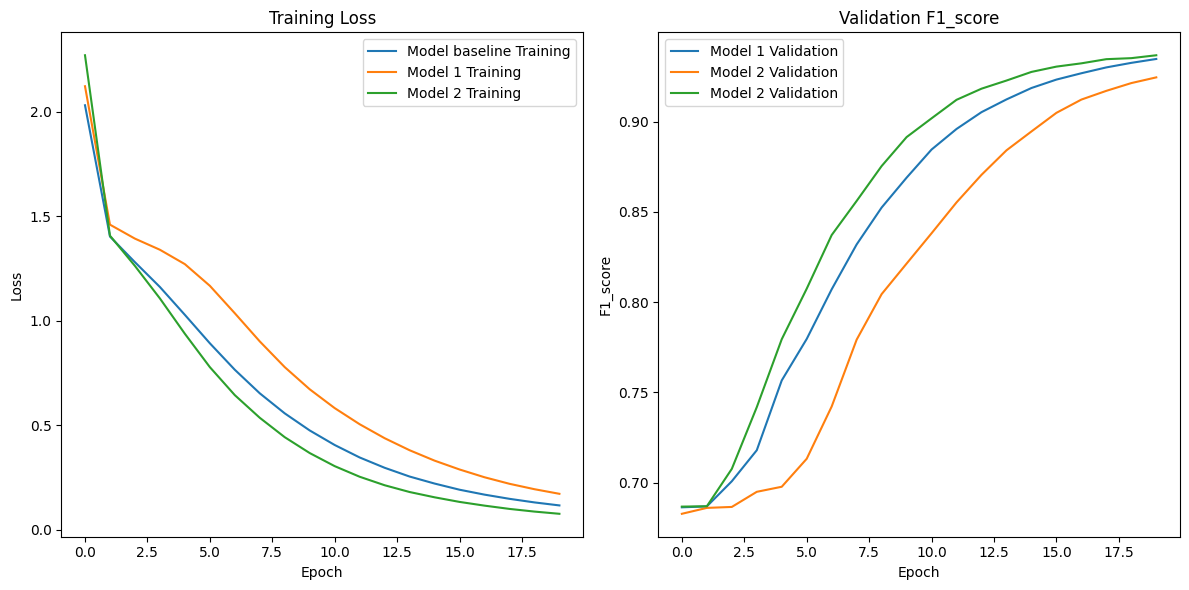

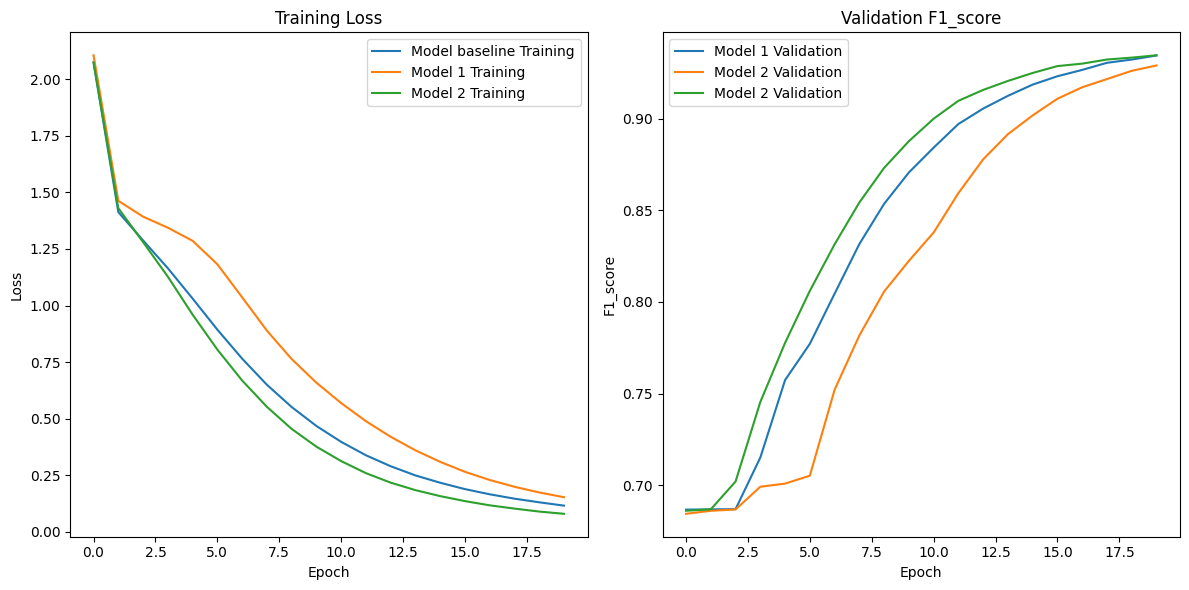

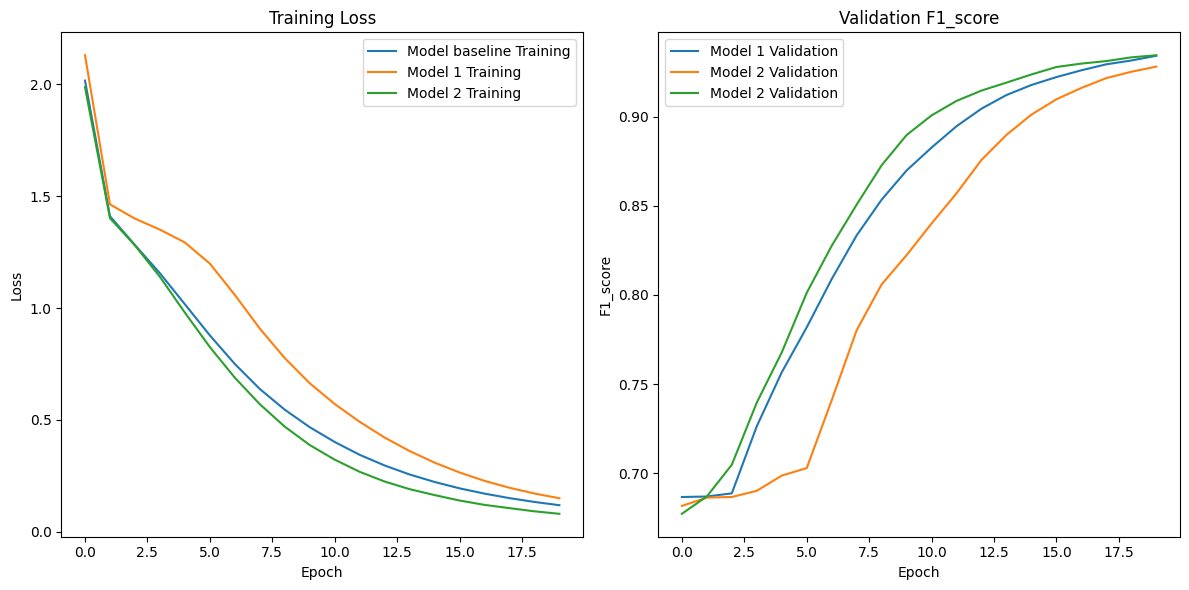

In [47]:
# Compare first seeds
compare_model_performance(histories_baseline[0], histories_model_1[0], histories_model_2[0], metric='f1_score')

# Compare second seeds
compare_model_performance(histories_baseline[1], histories_model_1[1], histories_model_2[1], metric='f1_score')

# Compare third seeds
compare_model_performance(histories_baseline[2], histories_model_1[2], histories_model_2[2], metric='f1_score')



The best model is the model 2.

In [74]:
best_models = models2
best_scores = model2_scores
best_cms = model2_cms

6.3 Compare errors made on validation and test set

In [137]:
# Define a simple function to compute the average of the scores
def average_score(scores):
    total = 0
    for score in scores:
        total += score
    return(round(total/len(scores), 3))

# Create a function to get an average confusion matrix from the three confusion matrices
def cm_compare(cms1, cms2):
    average_cm1 ={
        'tokens': cms1[0]['tokens'],
        'average_f1-score': round((cms1[0]['f1-score'] + cms1[1]['f1-score'] + cms1[2]['f1-score']) / 3, 3)
    }
    average_cm2 ={
        'tokens': cms2[0]['tokens'],
        'average_f1-score': round((cms2[0]['f1-score'] + cms2[1]['f1-score'] + cms2[2]['f1-score']) / 3, 3)
    }

    average_cm1 = pd.DataFrame(average_cm1)
    average_cm1 = pd.DataFrame(average_cm1)

    comparison_cm = {
        'tokens' : average_cm1['tokens'],
        'f1-score validation' : average_cm1['average_f1-score'],
        'f1-score test' : average_cm2['average_f1-score'] 
    }
    comparison_cm = pd.DataFrame(comparison_cm)
    print(comparison_cm)
    return comparison_cm

def plot_results(cm):
    val_values = cm['f1-score validation']
    test_values = cm['f1-score test']
    xvalues = cm['tokens']
    
    plt.figure(figsize=(12, 6))
    plt.plot(xvalues, val_values, label='Validation results')
    plt.plot(xvalues, test_values, label='Test results')

    plt.xlabel('tokens')
    plt.ylabel('f1 score')
    plt.title('f1 score token by token on validation and test set')
    plt.legend()
    plt.show()
    return 

def compute_predictions(model, X):
    ypred = model.predict(X, batch_size=batch_size)
    ypred_max = np.argmax(ypred, axis=-1)
    return ypred_max

def heatmap(model, X, y):
    ypred = compute_predictions(model, X)
    ytrue = np.argmax(y, axis=-1).flatten()
    string_punctuation_tokens = [str(item) for item in punctuation_tokens]
    index = [value for key, value in tag_tokenizer.index_word.items() if key not in punctuation_tokens]
    
    
    columns = [str(label) for label in range(NUM_CLASSES)]
    rows = [str(label) for label in range(NUM_CLASSES)]
    df = pd.DataFrame(np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int), columns=columns, index=rows)
    
    for true_label, pred_label in zip(ytrue, ypred.flatten()):
        df.at[str(true_label), str(pred_label)] += 1
    df = df.drop(columns=df.columns.intersection(string_punctuation_tokens),
             index=df.index.intersection(string_punctuation_tokens))
    df.columns = index
    df.index = index

    plt.figure(figsize=(20, 15))
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black', cbar=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Tag')
    plt.ylabel('True Tag')
    plt.show()
    return df


In [91]:
# Let's see the results on the test set
test_scores, test_cms = cm_printing(Xtest, ytest, models2)


6/6 [==============================] - 0s 67ms/step
   tokens  total_occurences    TP   FP   FN  f1-score
0      nn              2368  1947  443  421      0.82
1      in              1629  1580   66   49      0.96
2     nnp              1490  1071  267  419      0.76
3      dt              1335  1321   16   14      0.99
4     nns               938   754  193  184      0.80
5      jj               912   693  329  219      0.72
6      cd               857   705  113  152      0.84
7     vbd               634   531   78  103      0.85
8      rb               380   306  125   74      0.75
9      vb               402   356   91   46      0.84
10     cc               365   364    5    1      0.99
11     to               385   385    0    0      1.00
12    vbn               365   244  108  121      0.68
13    vbz               279   245   64   34      0.83
14    prp               192   190    5    2      0.98
15    vbg               220   118   79  102      0.57
16    vbp               134   

In [86]:
# Compare the difference class to class and the total f1 score on test and validation
comparison_cm = cm_compare(best_cms, test_cms)

average_score_val = average_score(best_scores)
average_score_test = average_score(test_scores)
print('\n\nF1 validation score: ', average_score_val)
print('\nF1 test score: ', average_score_test)

   tokens  f1-score validation  f1-score test
0      nn                0.810          0.817
1      in                0.963          0.963
2     nnp                0.727          0.750
3      dt                0.990          0.990
4     nns                0.760          0.787
5      jj                0.713          0.707
6      cd                0.817          0.847
7     vbd                0.797          0.850
8      rb                0.760          0.757
9      vb                0.820          0.853
10     cc                0.990          0.993
11     to                1.000          1.000
12    vbn                0.680          0.663
13    vbz                0.830          0.837
14    prp                0.980          0.980
15    vbg                0.543          0.527
16    vbp                0.750          0.763
17     md                0.963          0.980
18    pos                0.980          0.987
19   prp$                0.993          0.987
20      $                0.993    

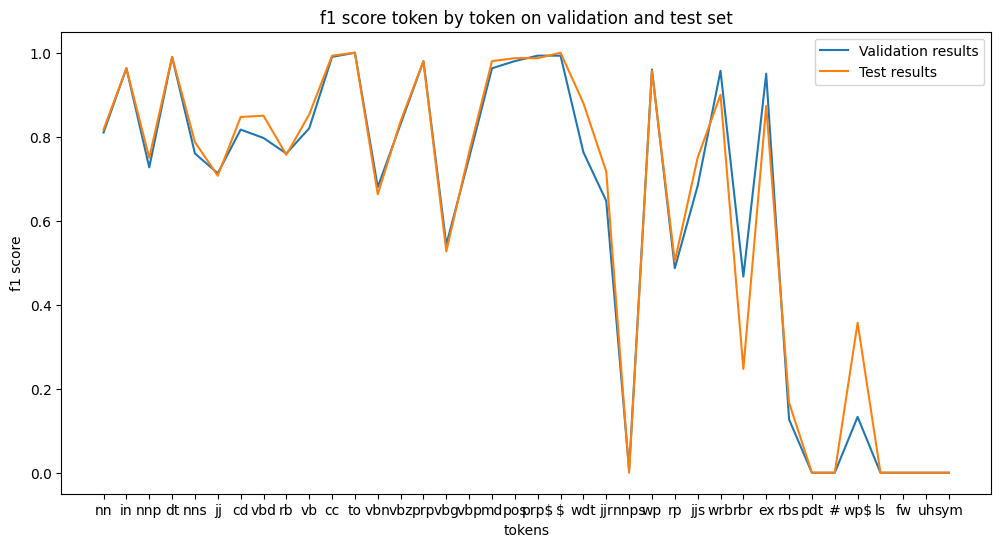

In [97]:
# Plot the results
plot_results(comparison_cm)

11/11 [==============================] - 1s 44ms/step


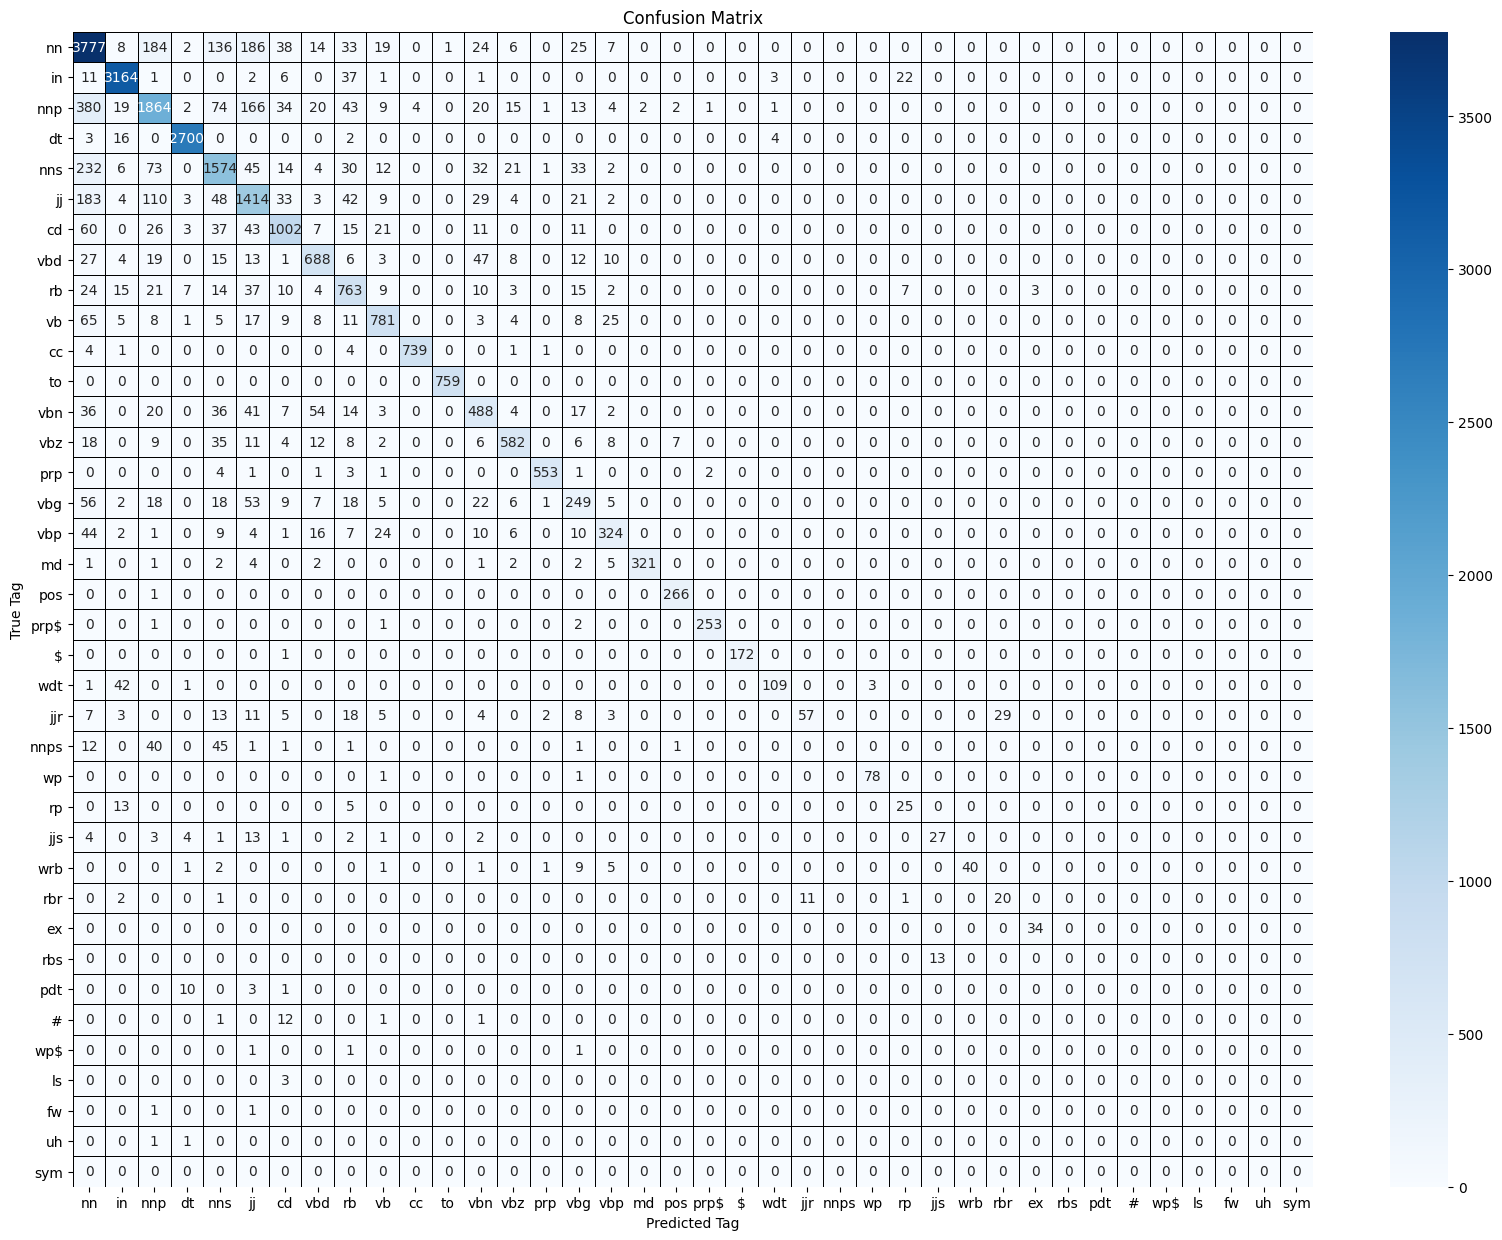

6/6 [==============================] - 0s 50ms/step


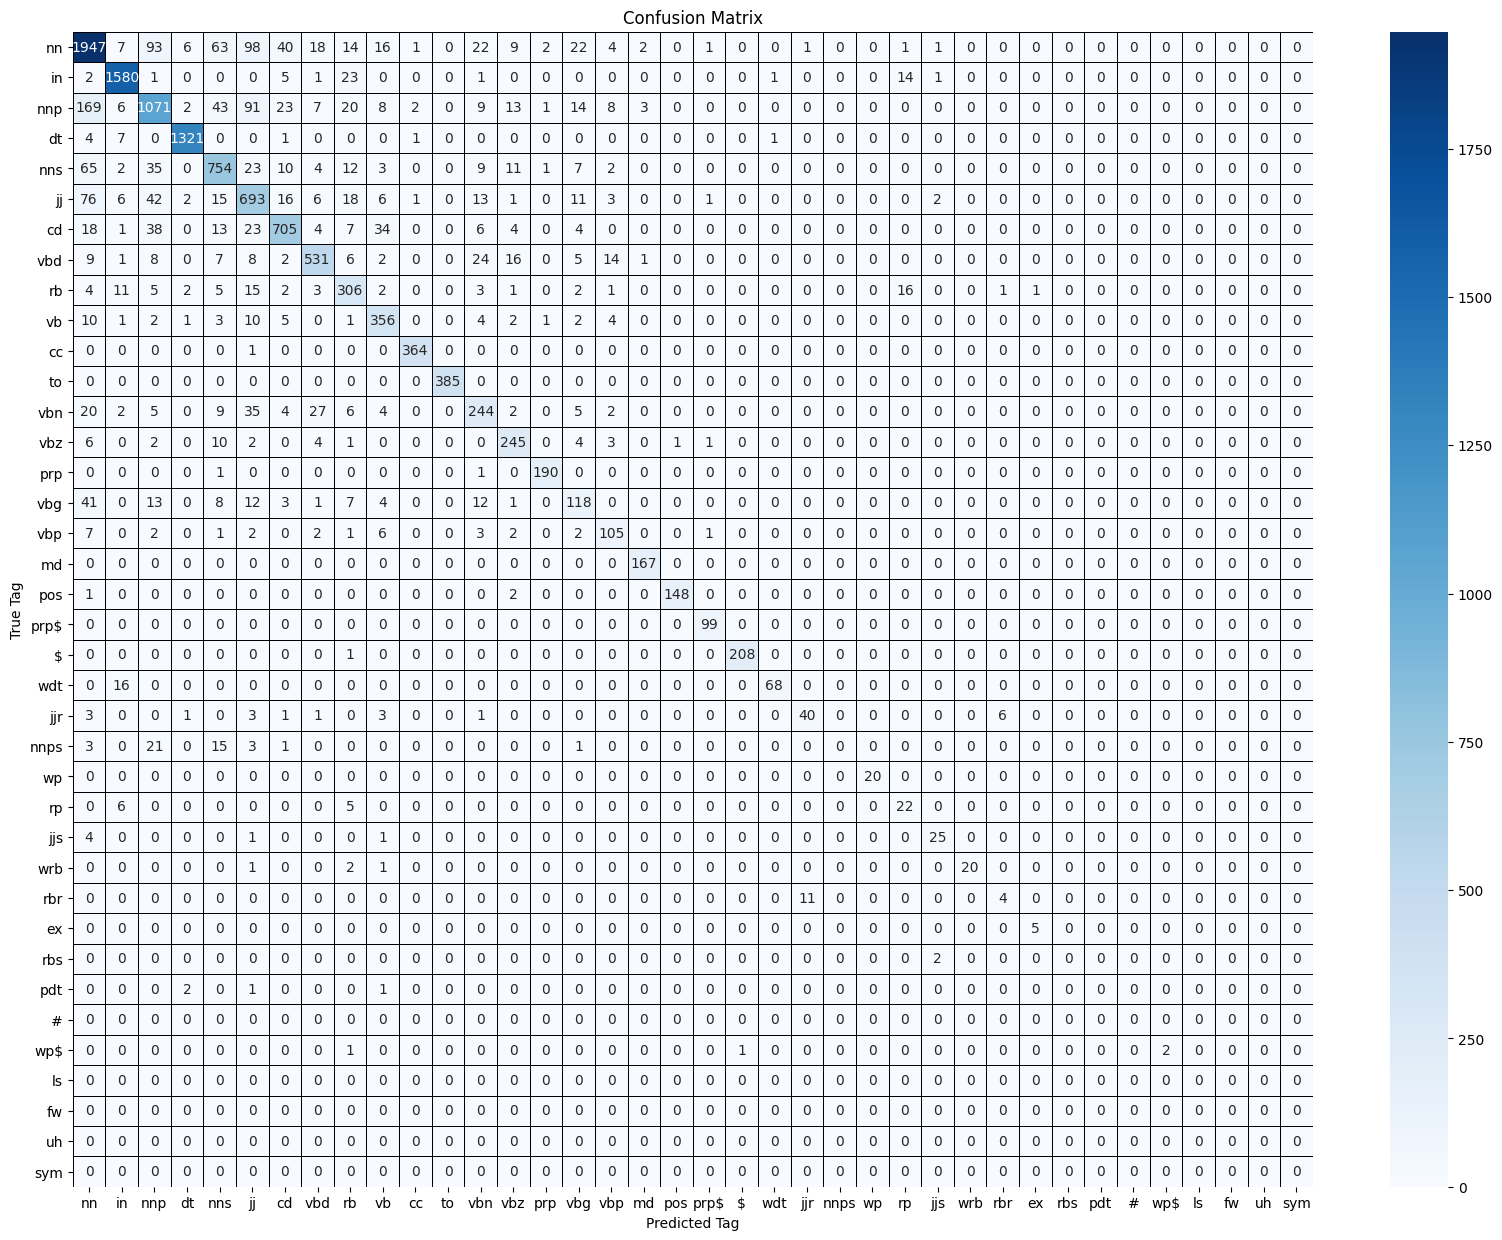

In [138]:
# Let'see on detail the errors made by the model on validation and test
heatmap_val = heatmap(bases[0], Xval, yval)
heatmap_test = heatmap(models2[0], Xtest, ytest)

6.4 Error aggregation


To go deeper in the error analysis we divided the tags in 10 macro-categories:
 1. **Noun Tags:**
     - 'nn': Noun
     - 'nnp': Proper Noun
     - 'nns': Plural Noun
     - 'nnps': Plural Proper Noun
2. **Determiner Tags:**
     - 'dt': Determiner
3. **Adjective Tags:**
     - 'jj': Adjective
     - 'jjr': Comparative Adjective
     - 'jjs': Superlative Adjective
4. **Verb Tags:**
     - 'vb': Verb
     - 'vbd': Past Tense Verb
     - 'vbn': Past Participle Verb
     - 'vbz': Third Person Singular Present Verb
     - 'vbz': Gerund or Present Participle Verb
     - 'vbp': Non-3rd Person Singular Present Verb
5. **Adverb Tags:**
     - 'rb': Adverb
     - 'rbr': Comparative Adverb
     - 'rbs': Superlative Adverb
6. **Pronoun Tags:**
     - prp: Pronoun
     - prp$: Possessive Pronoun
7. **Preposition and Conjunction Tags:**
     - in: Preposition
     - cc: Conjunction
8. **Modal Tags:**
     - md: Modal
9. **Other Tags:**
     - pos: Possessive Ending
     - rp: Particle
     - uh: Interjection
     - cd: Cardinal Number
     - $: Symbol (Dollar)
     - #: Symbol (Pound)
     - wdt: Wh-determiner
     - wp: Wh-pronoun
     - wp$: Possessive Wh-pronoun
     - wrb: Wh-adverb
     - pdt: Predeterminer
     - ls: List Item Marker
     - fw: Foreign Word
     - ex: Existential There



11/11 [==============================] - 1s 43ms/step


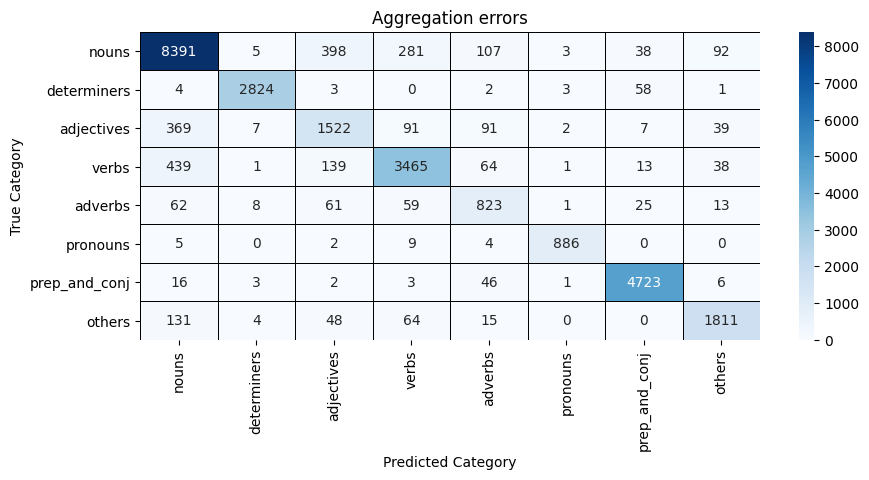

,nouns,determiners,adjectives,verbs,adverbs,pronouns,prep_and_conj,others
nouns,8391,5,398,281,107,3,38,92
determiners,4,2824,3,0,2,3,58,1
adjectives,369,7,1522,91,91,2,7,39
verbs,439,1,139,3465,64,1,13,38
adverbs,62,8,61,59,823,1,25,13
pronouns,5,0,2,9,4,886,0,0
prep_and_conj,16,3,2,3,46,1,4723,6
others,131,4,48,64,15,0,0,1811


In [175]:
# Tags division into categories
nouns = ['nn', 'nnp', 'nns', 'nnps']
determiners = ['dt', 'pdt', 'wdt']
adjectives = ['jj', 'jjr', 'jjs']
verbs = ['vb', 'vbd', 'vbn', 'vbz', 'vbp', 'vbg']
adverbs = ['rb', 'rbr', 'rbs', 'wrb']
pronouns = ['prp', 'prp$', 'wp', 'wp$']
prepositions_and_conjunctions = ['cc', 'in', 'rp', 'to']
others = ['cd', 'ex', 'fw', 'ls', 'md', 'pos', 'sym', 'uh', '$', '#']

def aggregative_matrix(model, X, y):
    nouns_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in nouns]
    determiners_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in determiners]
    adjectives_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in adjectives]
    verbs_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in verbs]
    adverbs_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in adverbs]
    pronouns_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in pronouns]
    prepositions_and_conjunctions_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in prepositions_and_conjunctions]
    others_tokens = [key for key, value in tag_tokenizer.index_word.items() if value in others]
    categories = ['nouns_tokens', 'determiners_tokens', 'adjectives_tokens', 'verbs_tokens', 'adverbs_tokens', 'pronouns_tokens', 'prepositions_and_conjunctions_tokens', 'others_tokens']
    categories_tokens = [1, 2, 3, 4, 5, 6, 7, 8]

    ypred = compute_predictions(model, X)
    ytrue = np.argmax(y, axis=-1).flatten()

    # Convert predictions into predictions on categories
    for i in range(ypred.shape[0]):
        for j in range(ypred.shape[1]):
            if ypred[i, j] in nouns_tokens:
                ypred[i, j] = 1
            elif ypred[i, j] in determiners_tokens:
                ypred[i, j] = 2
            elif ypred[i, j] in adjectives_tokens:
                ypred[i, j] = 3
            elif ypred[i, j] in verbs_tokens:
                ypred[i, j] = 4
            elif ypred[i, j] in adverbs_tokens:
                ypred[i, j] = 5
            elif ypred[i, j] in pronouns_tokens:
                ypred[i, j] = 6
            elif ypred[i, j] in prepositions_and_conjunctions_tokens:
                ypred[i, j] = 7
            elif ypred[i, j] in others_tokens:
                ypred[i, j] = 8
            else:
                ypred[i, j] = 0
        
     # Convert true values into true categories values
    for i in range(ytrue.shape[0]):
        if ytrue[i] in nouns_tokens:
            ytrue[i] = 1
        elif ytrue[i] in determiners_tokens:
            ytrue[i] = 2
        elif ytrue[i] in adjectives_tokens:
            ytrue[i] = 3
        elif ytrue[i] in verbs_tokens:
            ytrue[i] = 4
        elif ytrue[i] in adverbs_tokens:
            ytrue[i] = 5
        elif ytrue[i] in pronouns_tokens:
            ytrue[i] = 6
        elif ytrue[i] in prepositions_and_conjunctions_tokens:
            ytrue[i] = 7
        elif ytrue[i] in others_tokens:
            ytrue[i] = 8
        else:
            ytrue[i] = 0
    
    columns = [str(label) for label in range(len(categories)+1)]
    rows = [str(label) for label in range(len(categories)+1)]
    df = pd.DataFrame(np.zeros((len(categories)+1, len(categories)+1), dtype=int), columns=columns, index=rows)

    for true_label, pred_label in zip(ytrue, ypred.flatten()):
        if true_label != 0 and pred_label != 0:
            df.at[str(true_label), str(pred_label)] += 1

    new_columns = {'1': 'nouns', 
                   '2': 'determiners', 
                   '3': 'adjectives',
                   '4': 'verbs',
                   '5': 'adverbs',
                   '6': 'pronouns',
                   '7': 'prep_and_conj',
                   '8': 'others'}
    df.rename(columns=new_columns, inplace=True)
    new_indices = {'1': 'nouns', 
                   '2': 'determiners', 
                   '3': 'adjectives',
                   '4': 'verbs',
                   '5': 'adverbs',
                   '6': 'pronouns',
                   '7': 'prep_and_conj',
                   '8': 'others'}
    df.rename(index=new_indices, inplace=True)
    df = df.drop(index='0', columns='0')

    plt.figure(figsize=(10, 4))
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black', cbar=True)
    plt.title('Aggregation errors')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()
    return df


11/11 [==============================] - 0s 40ms/step


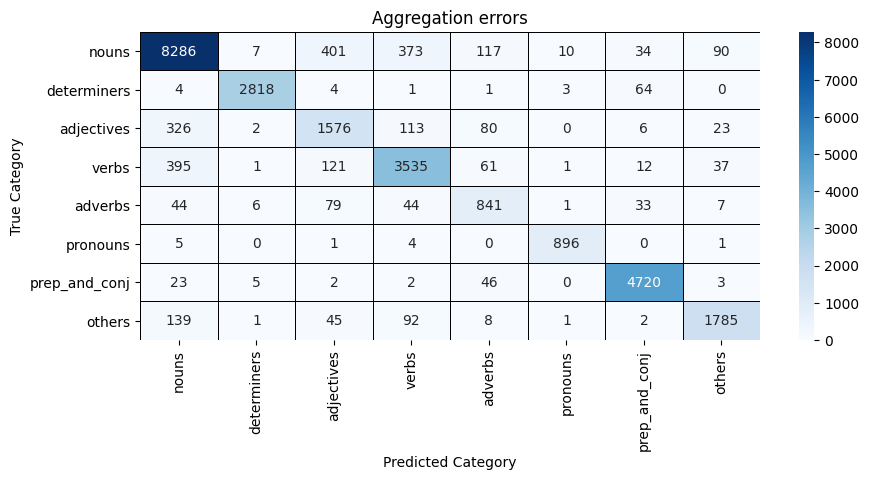

,nouns,determiners,adjectives,verbs,adverbs,pronouns,prep_and_conj,others
nouns,8286,7,401,373,117,10,34,90
determiners,4,2818,4,1,1,3,64,0
adjectives,326,2,1576,113,80,0,6,23
verbs,395,1,121,3535,61,1,12,37
adverbs,44,6,79,44,841,1,33,7
pronouns,5,0,1,4,0,896,0,1
prep_and_conj,23,5,2,2,46,0,4720,3
others,139,1,45,92,8,1,2,1785


In [177]:
# Error analysis on the validation set
aggregative_matrix(models2[0], Xval, yval)

6/6 [==============================] - 0s 51ms/step


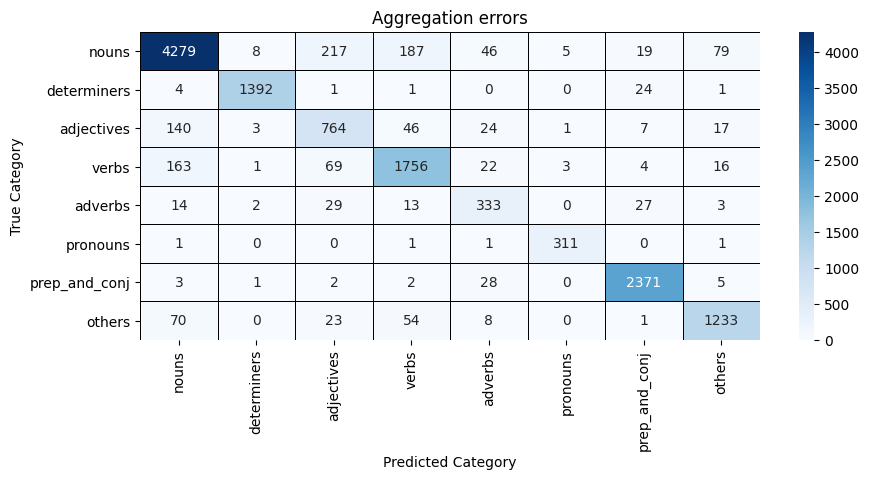

,nouns,determiners,adjectives,verbs,adverbs,pronouns,prep_and_conj,others
nouns,4279,8,217,187,46,5,19,79
determiners,4,1392,1,1,0,0,24,1
adjectives,140,3,764,46,24,1,7,17
verbs,163,1,69,1756,22,3,4,16
adverbs,14,2,29,13,333,0,27,3
pronouns,1,0,0,1,1,311,0,1
prep_and_conj,3,1,2,2,28,0,2371,5
others,70,0,23,54,8,0,1,1233


In [178]:
# Error analysis on the test set
aggregative_matrix(models2[0], Xtest, ytest)